In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
#初期密度
sigma0 = 0.853

In [4]:
#サイズと初期質量
def m0(x):
    val = 0.0610*x**1.5-1.95
    return val

In [5]:
def r(x):
    V = m0(x)/sigma0
    r = ((0.75/np.pi)*V)**(1/3)
    return r

In [6]:
#吸水量
def A(t, x, k1, k2, k3, k4):
    if t == 0:
        return 0
    else:
        val = (k1*x+k2)*np.log10(t)+(k3*x+k4)
        return val

In [7]:
#密度変化
def sigma(t, x, k1, k2, k3, k4):
    m_ = 1 + A(t, x, k1, k2, k3, k4)/m0(x)
    sigma = sigma0 * m_
    return sigma

In [8]:
def settling_velocity(sigma_val, d, density_fluid=1.0, g=981, dynamic_viscosity=0.01, tol=1e-6):
    """
    修正ドラグモデルに基づく沈降速度を計算
    
    Args:
    - r_val: 粒子半径（cm）
    - sigma_val: 粒子密度（g/cm³）
    - density_fluid: 流体密度（g/cm³, デフォルト=1.0）
    - g: 重力加速度（cm/s², デフォルト=981）
    - dynamic_viscosity: 動粘性係数（dyn·s/cm², デフォルト=0.01）
    - tol: 許容誤差（デフォルト=1e-6）
    
    Returns:
    - 修正された沈降速度（cm/s）
    """

    #r_val = r(x)
    #sigma_val = sigma(t, x, k1, k2, k3, k4)

    # 初期値
    #d = 2 * r_val  # 粒径
    r_val = d/2
    v = 0.01  # 初期速度仮定（cm/s）
    error = 1.0  # 誤差初期化]
    l_Re = []
    l_v = []

    while error > tol:
        # レイノルズ数を計算
        reynolds_number = max((density_fluid * v * d) / dynamic_viscosity, 1e-10)
        l_Re.append(reynolds_number)
        
        # ドラグ係数を計算
        if reynolds_number < 2:
            C_d = 24 / reynolds_number
        elif reynolds_number <= 800:
            C_d = 24 / reynolds_number * (1 + 0.15 * reynolds_number**0.687)
        else:
            C_d = 0.44

        if sigma_val < density_fluid:
            v_new = 0 
        else:
            # 修正沈降速度を計算
            v_new = ( (4/3) * (r_val * (sigma_val - density_fluid) * g) / (density_fluid * C_d) )**0.5
        
        # 誤差を計算
        error = abs(v_new - v)
        v = v_new
        l_v.append(v)

    return v

In [9]:
def h(v, t, h0=0):
    delta = 0.05
    h_val = h0
    
    for i in np.arange(0, t, delta):
        h_val += delta*v
    return h_val

In [10]:
#係数設定
#拡散係数
k = np.array([ 
    [0.0271, -0.498, 0.0156, 1.11], 
    [0.0509, -1.08, -0.0317, 3.40], 
    [0.0556, -1.44, -0.0320, 3.47],
])

k1, k2, k3, k4 = k[0]
k1, k2, k3, k4

(0.0271, -0.498, 0.0156, 1.11)

In [11]:
#初期値設定
t = np.arange(0, 61, 1)  # time values
x = np.arange(30, 65, 5)  # x-direction values
d = [2*r(i) for i in x]

sigma_matrix = np.zeros((len(t), len(x)))
v_matrix = np.zeros((len(t), len(x)))
v_matrix_const = np.zeros((len(t), len(x)))
h_matrix = np.zeros((len(t), len(x)))
h_matrix_const = np.zeros((len(t), len(x)))

In [12]:
#密度変化計算
for j_idx, j in enumerate(x):
    sigma_matrix[:, j_idx] = [sigma(i, j, k1, k2, k3, k4) for i in t]

In [13]:
#沈降速度計算
for dt, i in enumerate(t):
    for dx, j in enumerate(d):
        sigma_val = sigma_matrix[dt, dx]
        v_matrix[dt, dx] = settling_velocity(sigma_val, j)
        v_matrix_const[dt, dx] = settling_velocity(1.07, j)

In [14]:
#位置計算
for dt, i in enumerate(t):
    for dx, j in enumerate(x):
        v = v_matrix[dt, dx]
        v_const = v_matrix_const[dt, dx]
        h_matrix[dt, dx] = h(v, i)
        h_matrix_const[dt, dx] = h(v_const, i)

Text(0, 0.5, 'Density [g/cm3]')

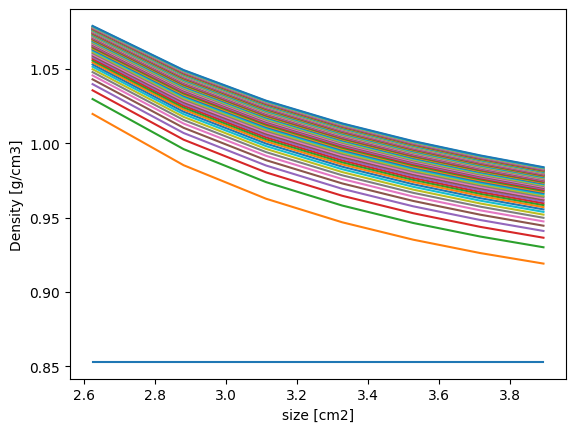

In [15]:
#グラフ可視化
for dt, i in enumerate(t):
    plt.plot(d, sigma_matrix[dt, :])

plt.xlabel("size [cm2]")
plt.ylabel("Density [g/cm3]")

Text(0, 0.5, 'Settling Velocity [cm/s]')

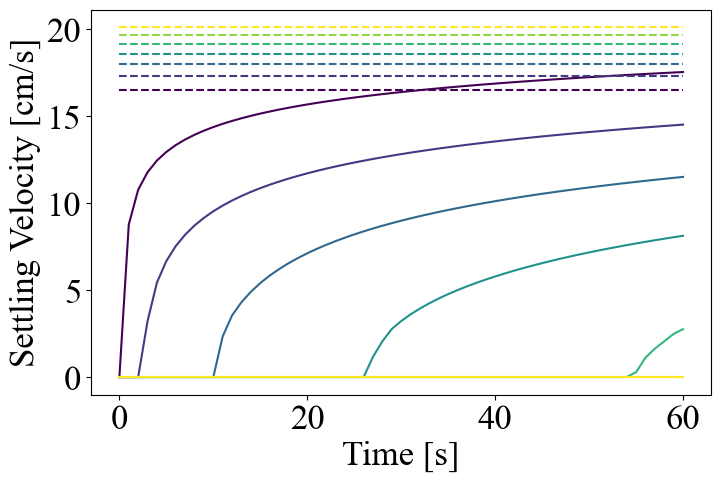

In [22]:
#グラフ可視化
# 画像サイズの指定 (幅 x 高さ, 単位はインチ)
cmap = cm.viridis
colors = cmap(np.linspace(0, 1, len(x)))  # x のデータ数に応じてカラーマップから色を取得

plt.figure(figsize=(8, 5))  # 例: 幅 8インチ、高さ 6インチ

# フォント設定
plt.rcParams["font.family"] = "Times New Roman"  # 使用するフォント（例: Arial）
plt.rcParams["font.size"] = 25  # フォントサイズの設定

for dx, j in enumerate(x):
    #plt.plot(d, v_matrix[dt, :], label = f"{i}s")
    plt.plot(t, v_matrix[:, dx], c = colors[dx])
    plt.plot(t, v_matrix_const[:, dx], linestyle = "dashed", c = colors[dx])

#plt.ylim(0, 30)
plt.xlabel("Time [s]")
plt.ylabel("Settling Velocity [cm/s]")
#plt.legend()
#plt.savefig(r"C:\Users\students\OneDrive\デスクトップ\移動用\修論\settling velocity\Velocity\constrained2.png", bbox_inches="tight")

Text(0, 0.5, 'Displacement [cm]')

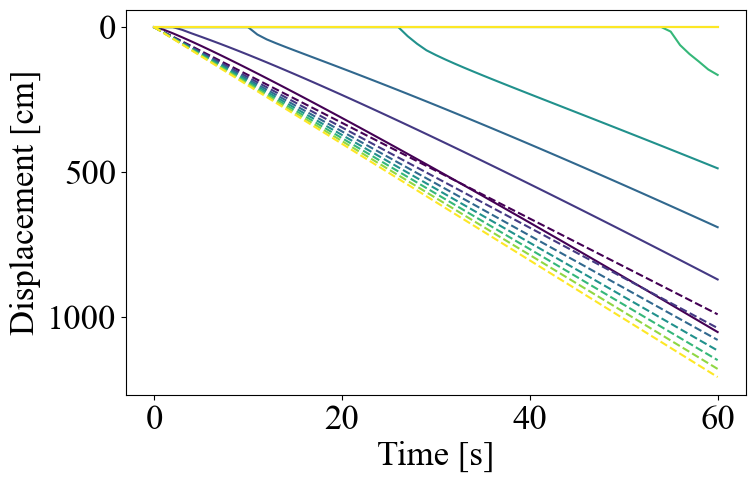

In [24]:
#グラフ可視化
#グラフ可視化
# 画像サイズの指定 (幅 x 高さ, 単位はインチ)
cmap = cm.viridis
colors = cmap(np.linspace(0, 1, len(x)))  # x のデータ数に応じてカラーマップから色を取得

plt.figure(figsize=(8, 5))  # 例: 幅 8インチ、高さ 6インチ

# フォント設定
plt.rcParams["font.family"] = "Times New Roman"  # 使用するフォント（例: Arial）
plt.rcParams["font.size"] = 25  # フォントサイズの設定

for dx, j in enumerate(x):
    #plt.plot(d, h_matrix[dt, :], label = f"{i}s")
    plt.plot(t, h_matrix[:, dx], c = colors[dx])
    plt.plot(t, h_matrix_const[:, dx], linestyle = "dashed", c = colors[dx])

#plt.ylim(0, 2000)
plt.gca().invert_yaxis()
plt.xlabel("Time [s]")
plt.ylabel("Displacement [cm]")
#plt.legend()
#plt.savefig(r"C:\Users\students\OneDrive\デスクトップ\移動用\修論\settling velocity\Displacement\constrained2.png", bbox_inches="tight")

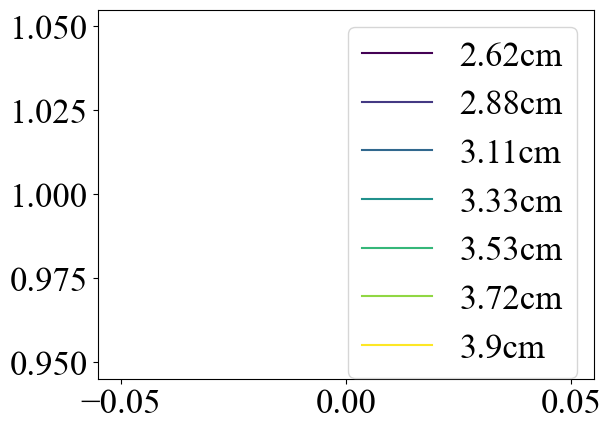

In [29]:
cmap = cm.viridis
colors = cmap(np.linspace(0, 1, len(x)))  # x のデータ数に応じてカラーマップから色を取得
for di, i in enumerate(d):
    plt.plot(1, label = f"{round(i, 2)}cm", c = colors[di])

plt.legend()